## 1. Import Libraries

Import necessary libraries for data processing, visualization, and deep learning.

In [1]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning - Keras/TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# PyTorch (for ONNX export)
import torch
import torch.nn as nn

# ONNX Runtime
import onnxruntime as ort
import onnx

print(f"TensorFlow: {tf.__version__}")
print(f"PyTorch: {torch.__version__}")

TensorFlow: 2.20.0
PyTorch: 2.9.1+cpu


## 2. Data Loading & Exploration

Load the SQL injection dataset and explore its structure.

In [2]:
# Load the dataset
df = pd.read_csv('Modified_SQL_Dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (30919, 2)

Columns: ['Query', 'Label']


,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


### 2.1 Class Distribution

Examine the distribution of normal vs SQLi queries.

Normal queries:  19,537 (63.2%)
SQLi queries:    11,382 (36.8%)
Total queries:   30,919


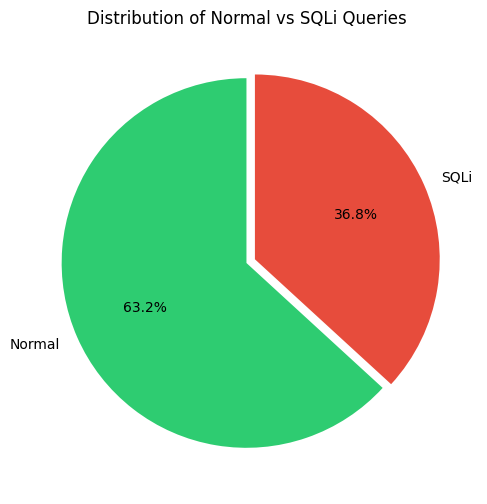

In [3]:
# Calculate class distribution
class_counts = df['Label'].value_counts()
normal_count = class_counts.get(0, 0)
sqli_count = class_counts.get(1, 0)

print(f"Normal queries:  {normal_count:,} ({normal_count/len(df)*100:.1f}%)")
print(f"SQLi queries:    {sqli_count:,} ({sqli_count/len(df)*100:.1f}%)")
print(f"Total queries:   {len(df):,}")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['#2ecc71', '#e74c3c']
ax.pie([normal_count, sqli_count], labels=['Normal', 'SQLi'], 
       colors=colors, autopct='%1.1f%%', startangle=90, explode=(0, 0.05))
ax.set_title('Distribution of Normal vs SQLi Queries')
plt.show()

### 2.2 Sample Queries

Examine example queries from each class to understand the data format.

In [4]:
# Sample normal queries
print("=" * 80)
print("Sample NORMAL queries:")
print("=" * 80)
for q in df[df['Label'] == 0]['Query'].sample(5, random_state=42).values:
    print(f"  {q[:80]}" + ("..." if len(q) > 80 else ""))

print("\n" + "=" * 80)
print("Sample SQLi queries:")
print("=" * 80)
for q in df[df['Label'] == 1]['Query'].sample(5, random_state=42).values:
    print(f"  {q[:80]}" + ("..." if len(q) > 80 else ""))

Sample NORMAL queries:
  completorio
  SELECT COUNT ( DISTINCT appropriate )  FROM completely
  entendimiento
  madrigal puigb
  SELECT number FROM may

Sample SQLi queries:
  1' and 3580  =    (  select count  (  *  )   from domain.domains as t1,domain.co...
  select dbms_pipe.receive_message  (  chr  (  66  )  ||chr  (  67  )  ||chr  (  7...
  -7996"   )    )    or 4747  =  dbms_utility.sqlid_to_sqlhash   (    (   chr  (  ...
  1   )    )    as xvyi where 6701  =  6701 union all select null,null,null,null#
  1%"   )    )    waitfor delay '0:0:5' and    (    (   "%"  =  "


### 2.3 Query Length Analysis

Analyze query lengths to determine appropriate maximum sequence length.

Query length statistics:
  Min:             1
  Max:             5370
  Mean:            68.9
  Median:          48.0
  95th percentile: 223.0


C:\Users\jnz\AppData\Local\Temp\ipykernel_20360\2254680280.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([normal_lengths, sqli_lengths], labels=['Normal', 'SQLi'])


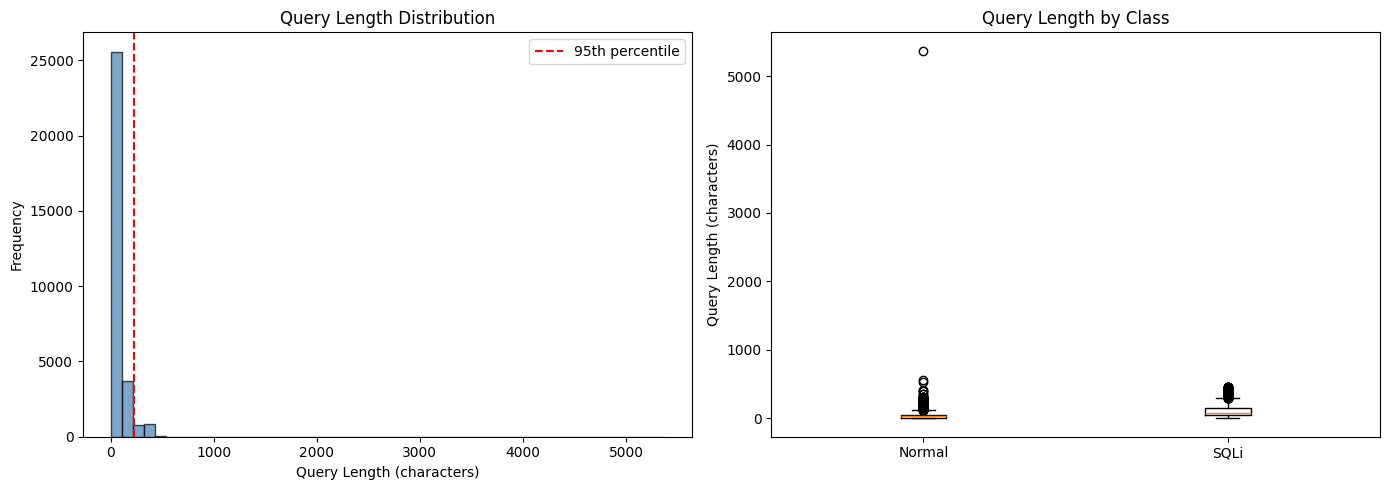

In [5]:
# Get texts and labels
texts = df['Query'].astype(str).values
labels = df['Label'].values

# Analyze query lengths
lengths = [len(t) for t in texts]

print("Query length statistics:")
print(f"  Min:             {min(lengths)}")
print(f"  Max:             {max(lengths)}")
print(f"  Mean:            {np.mean(lengths):.1f}")
print(f"  Median:          {np.median(lengths):.1f}")
print(f"  95th percentile: {np.percentile(lengths, 95):.1f}")

# Visualize length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.percentile(lengths, 95), color='red', linestyle='--', label='95th percentile')
axes[0].set_title('Query Length Distribution')
axes[0].set_xlabel('Query Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot by class
normal_lengths = [len(t) for t, l in zip(texts, labels) if l == 0]
sqli_lengths = [len(t) for t, l in zip(texts, labels) if l == 1]
axes[1].boxplot([normal_lengths, sqli_lengths], labels=['Normal', 'SQLi'])
axes[1].set_title('Query Length by Class')
axes[1].set_ylabel('Query Length (characters)')

plt.tight_layout()
plt.show()

## 3. Text Preprocessing

### 3.1 Character-Level Tokenization

Build a character vocabulary and encode texts as sequences of character indices.

In [6]:
# Set max length (use 95th percentile to cover most cases)
MAX_LEN = int(np.percentile(lengths, 95))
print(f"Using MAX_LEN = {MAX_LEN}")

# Build character vocabulary from all texts
all_chars = set()
for text in texts:
    all_chars.update(text)

# Create char to index mapping (0=padding, 1=unknown)
char_to_idx = {char: idx + 2 for idx, char in enumerate(sorted(all_chars))}
char_to_idx['<PAD>'] = 0
char_to_idx['<UNK>'] = 1

VOCAB_SIZE = len(char_to_idx)
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"\nSample characters: {list(char_to_idx.keys())[:20]}...")

Using MAX_LEN = 223
Vocabulary size: 109

Sample characters: ['\x18', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2']...


In [7]:
def encode_text(text, char_to_idx, max_len):
    """Encode text to sequence of character indices with padding."""
    encoded = []
    for char in text[:max_len]:
        encoded.append(char_to_idx.get(char, char_to_idx['<UNK>']))
    
    # Pad to max_len
    while len(encoded) < max_len:
        encoded.append(char_to_idx['<PAD>'])
    
    return encoded

# Encode all texts
X = np.array([encode_text(t, char_to_idx, MAX_LEN) for t in texts])
y = labels

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nSample encoded (first 50 chars): {X[0][:50]}")

X shape: (30919, 223)
y shape: (30919,)

Sample encoded (first 50 chars): [ 5  3 82 85  3 83 74 66 86 79 72 72 83  3  3 11  3  3 66 66 55 44 48 40
 66 66  3  3 12  3  3 16 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


### 3.2 Train/Validation/Test Split

Split data into training (72%), validation (8%), and test (20%) sets.

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print(f"Training set:   {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set:       {X_test.shape[0]:,} samples")

# Class balance check
print(f"\nClass balance in training set:")
print(f"  Normal: {sum(y_train == 0):,} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  SQLi:   {sum(y_train == 1):,} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

Training set:   22,261 samples
Validation set: 2,474 samples
Test set:       6,184 samples

Class balance in training set:
  Normal: 14,066 (63.2%)
  SQLi:   8,195 (36.8%)


## 4. Model Architecture

Build a character-level LSTM classifier with:
- **Embedding layer**: Map character indices to dense vectors
- **SpatialDropout1D**: Regularization for sequential data
- **Stacked LSTMs**: Two LSTM layers for complex pattern learning
- **Dense layers**: Final classification with dropout

In [9]:
# Model hyperparameters
EMBEDDING_DIM = 64
LSTM_UNITS = 128
DROPOUT_RATE = 0.3

# Build model
model = keras.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    layers.SpatialDropout1D(DROPOUT_RATE),
    layers.LSTM(LSTM_UNITS, return_sequences=True),
    layers.LSTM(LSTM_UNITS // 2),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(64, activation='relu'),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\jnz\Documents\webattack-payload-detector\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training

Train the model with:
- **Early stopping**: Stop if validation loss doesn't improve for 3 epochs
- **Learning rate reduction**: Reduce LR when plateauing

In [10]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 205ms/step - accuracy: 0.7603 - loss: 0.4962 - val_accuracy: 0.9074 - val_loss: 0.2543 - learning_rate: 0.0010
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 74s 205ms/step - accuracy: 0.7603 - loss: 0.4962 - val_accuracy: 0.9074 - val_loss: 0.2543 - learning_rate: 0.0010
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.8518 - loss: 0.3132 - val_accuracy: 0.9580 - val_loss: 0.1704 - learning_rate: 0.0010
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.8518 - loss: 0.3132 - val_accuracy: 0.9580 - val_loss: 0.1704 - learning_rate: 0.0010
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 76s 219ms/step - accuracy: 0.9892 - loss: 0.0562 - val_accuracy: 0.9899 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 76s 219ms/step - accuracy: 0.9892 - loss: 0.0562 - val_accuracy: 0.9899 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 220ms/step - accuracy: 0.9

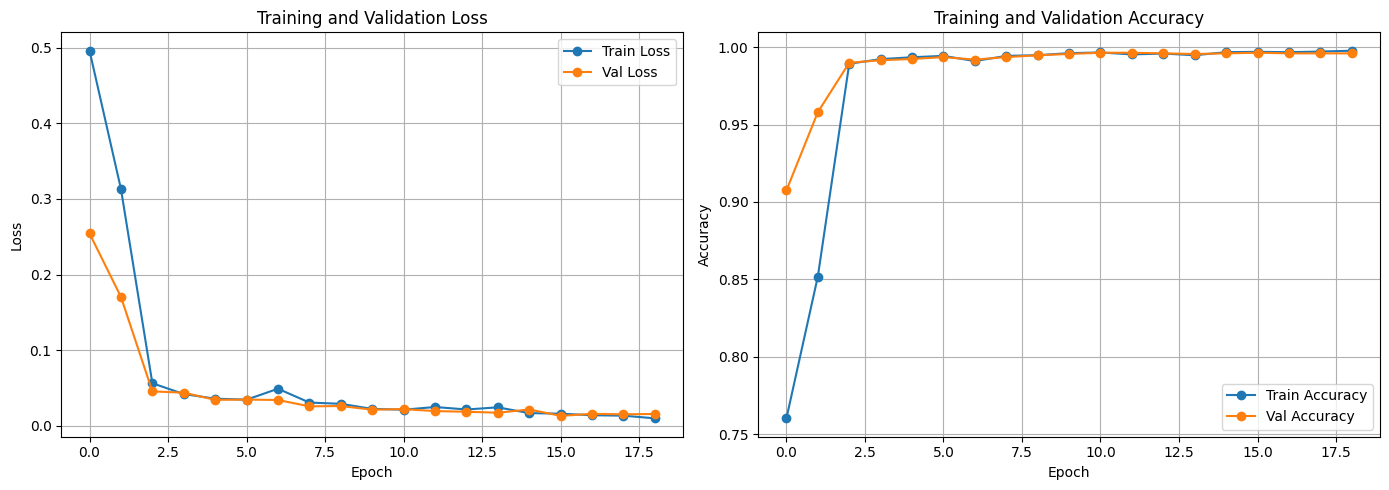

In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Val Loss', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 6. Model Evaluation

Evaluate the trained model on the test set.

In [12]:
# Predict on test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("Classification Report")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Normal', 'SQLi']))

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

194/194 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step
Classification Report
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      3908
        SQLi       1.00      0.99      0.99      2276

    accuracy                           1.00      6184
   macro avg       1.00      0.99      1.00      6184
weighted avg       1.00      1.00      1.00      6184

Test Accuracy: 0.9961


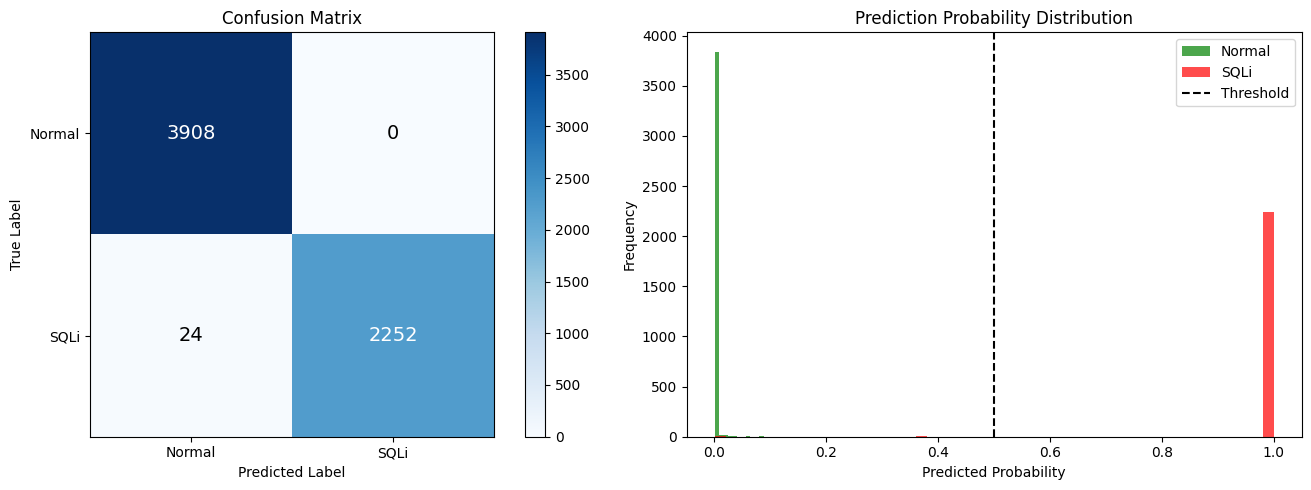

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
im = axes[0].imshow(cm, cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Normal', 'SQLi'])
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['Normal', 'SQLi'])
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, cm[i, j], ha='center', va='center', fontsize=14,
                     color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.colorbar(im, ax=axes[0])

# Prediction distribution
axes[1].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='Normal', color='green')
axes[1].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='SQLi', color='red')
axes[1].axvline(0.5, color='black', linestyle='--', label='Threshold')
axes[1].set_title('Prediction Probability Distribution')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Input Normalization

**Important Discovery**: The training data has a specific format with spaces around operators. For accurate predictions on new inputs, we must normalize inputs to match this format.

In [21]:
def normalize_sql_input(text):
    """
    Normalize input to match training data format.
    
    The training data has spaces around operators, so we need to
    add similar spacing to ensure consistent predictions.
    """
    text = re.sub(r'([=<>!]+)', r'  \1  ', text)  # Operators
    text = re.sub(r'([()])', r'  \1  ', text)      # Parentheses
    text = re.sub(r',', ' , ', text)               # Commas
    text = re.sub(r"'", " ' ", text)               # Single quotes
    text = re.sub(r'"', ' " ', text)               # Double quotes
    text = re.sub(r'\s+', ' ', text)               # Normalize spaces
    return text.strip().lower()


def predict_query(query, model, char_to_idx, max_len, normalize=True):
    """Predict if a query is SQLi or normal."""
    if normalize:
        query = normalize_sql_input(query)
    encoded = encode_text(query, char_to_idx, max_len)
    X = np.array([encoded])
    prob = model.predict(X, verbose=0)[0][0]
    label = "SQLi" if prob > 0.5 else "Normal"
    return label, prob


# Test predictions with normalization
test_queries = [
    # Normal queries
    ("laptop", "Normal"),
    ("search term", "Normal"),
    ("SELECT * FROM users WHERE id = 1", "Normal"),
    
    # SQLi queries
    ("' OR '1'='1' --", "SQLi"),
    ("admin' --", "SQLi"),
    ("1; DROP TABLE users --", "SQLi"),
    ("' UNION SELECT username, password FROM users --", "SQLi"),
    ("1' AND 1=1 --", "SQLi"),
]

print("Query Predictions (with normalization)")
print("=" * 80)
for query, expected in test_queries:
    label, prob = predict_query(query, model, char_to_idx, MAX_LEN)
    status = "✓" if label == expected else "✗"
    print(f"{status} [{label:6s}] (prob: {prob:.4f}) | {query[:50]}")

Query Predictions (with normalization)
✓ [Normal] (prob: 0.0008) | laptop
✓ [Normal] (prob: 0.0018) | search term
✗ [SQLi  ] (prob: 0.9994) | SELECT * FROM users WHERE id = 1
✓ [SQLi  ] (prob: 0.9997) | ' OR '1'='1' --
✓ [SQLi  ] (prob: 0.9995) | admin' --
✓ [SQLi  ] (prob: 0.9996) | 1; DROP TABLE users --
✓ [SQLi  ] (prob: 0.9996) | ' UNION SELECT username, password FROM users --
✓ [SQLi  ] (prob: 0.9996) | 1' AND 1=1 --


## 8. Save Model and Tokenizer

Save the Keras model and tokenizer configuration for later use.

In [15]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Save Keras model
model.save('models/sqli_lstm.keras')
print("✓ Saved Keras model: models/sqli_lstm.keras")

# Save tokenizer and config
tokenizer_config = {
    'char_to_idx': char_to_idx,
    'max_len': MAX_LEN,
    'vocab_size': VOCAB_SIZE
}

with open('models/sqli_tokenizer.json', 'w') as f:
    json.dump(tokenizer_config, f, indent=2)
print("✓ Saved tokenizer: models/sqli_tokenizer.json")

✓ Saved Keras model: models/sqli_lstm.keras
✓ Saved tokenizer: models/sqli_tokenizer.json


## 9. ONNX Export

Export the trained model to ONNX format for deployment. Since `tf2onnx` is incompatible with Python 3.13/TensorFlow 2.20, we use PyTorch as an intermediate step:

1. Define equivalent PyTorch model
2. Transfer Keras weights to PyTorch
3. Export PyTorch model to ONNX

### 9.1 PyTorch Model Definition

In [16]:
class SQLiLSTMExporter(nn.Module):
    """
    PyTorch equivalent of Keras LSTM for ONNX export.
    
    Architecture mirrors the Keras model:
    - Embedding(VOCAB_SIZE, 64)
    - LSTM(128, return_sequences=True)
    - LSTM(64)
    - Dense(64, relu)
    - Dense(1, sigmoid)
    """
    def __init__(self, vocab_size, embedding_dim=64, lstm_units=128, dense_size=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, lstm_units, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units // 2, batch_first=True)
        self.fc1 = nn.Linear(lstm_units // 2, dense_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: (batch, seq_len) - integer indices
        out = self.embedding(x)       # (batch, seq_len, embedding_dim)
        out, _ = self.lstm1(out)      # (batch, seq_len, lstm_units)
        out, _ = self.lstm2(out)      # (batch, seq_len, lstm_units//2)
        out = out[:, -1, :]           # Take last timestep: (batch, lstm_units//2)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

print(f"PyTorch SQLiLSTMExporter defined")
print(f"  VOCAB_SIZE:    {VOCAB_SIZE}")
print(f"  EMBEDDING_DIM: {EMBEDDING_DIM}")
print(f"  LSTM_UNITS:    {LSTM_UNITS}")
print(f"  MAX_LEN:       {MAX_LEN}")

PyTorch SQLiLSTMExporter defined
  VOCAB_SIZE:    109
  EMBEDDING_DIM: 64
  LSTM_UNITS:    128
  MAX_LEN:       223


### 9.2 Weight Transfer from Keras to PyTorch

In [17]:
# Create PyTorch model
pytorch_model = SQLiLSTMExporter(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS,
    dense_size=64
)

# Get Keras weights
keras_weights = model.get_weights()
print("Keras layer weights:")
for i, w in enumerate(keras_weights):
    print(f"  [{i}] shape: {w.shape}")

# Transfer weights from Keras to PyTorch
with torch.no_grad():
    # Layer 0: Embedding (vocab_size, embedding_dim)
    pytorch_model.embedding.weight.copy_(torch.tensor(keras_weights[0]))
    
    # LSTM1 weights (after SpatialDropout1D)
    # Keras: [kernel, recurrent_kernel, bias]
    pytorch_model.lstm1.weight_ih_l0.copy_(torch.tensor(keras_weights[1].T))
    pytorch_model.lstm1.weight_hh_l0.copy_(torch.tensor(keras_weights[2].T))
    pytorch_model.lstm1.bias_ih_l0.copy_(torch.tensor(keras_weights[3]))
    pytorch_model.lstm1.bias_hh_l0.zero_()
    
    # LSTM2 weights
    pytorch_model.lstm2.weight_ih_l0.copy_(torch.tensor(keras_weights[4].T))
    pytorch_model.lstm2.weight_hh_l0.copy_(torch.tensor(keras_weights[5].T))
    pytorch_model.lstm2.bias_ih_l0.copy_(torch.tensor(keras_weights[6]))
    pytorch_model.lstm2.bias_hh_l0.zero_()
    
    # Dense1: (lstm_units//2, 64)
    pytorch_model.fc1.weight.copy_(torch.tensor(keras_weights[7].T))
    pytorch_model.fc1.bias.copy_(torch.tensor(keras_weights[8]))
    
    # Dense2: (64, 1)
    pytorch_model.fc2.weight.copy_(torch.tensor(keras_weights[9].T))
    pytorch_model.fc2.bias.copy_(torch.tensor(keras_weights[10]))

pytorch_model.eval()
print("\n✓ Weights transferred from Keras to PyTorch")

Keras layer weights:
  [0] shape: (109, 64)
  [1] shape: (64, 512)
  [2] shape: (128, 512)
  [3] shape: (512,)
  [4] shape: (128, 256)
  [5] shape: (64, 256)
  [6] shape: (256,)
  [7] shape: (64, 64)
  [8] shape: (64,)
  [9] shape: (64, 1)
  [10] shape: (1,)

✓ Weights transferred from Keras to PyTorch


### 9.3 Verify Weight Transfer

In [18]:
# Verify predictions match between Keras and PyTorch
print("Keras vs PyTorch Prediction Comparison")
print("=" * 60)

test_samples = [
    "laptop",
    "' or 1 = 1 --",
    "admin' --",
    "SELECT * FROM users",
]

for query in test_samples:
    normalized = normalize_sql_input(query)
    encoded = encode_text(normalized, char_to_idx, MAX_LEN)
    
    # Keras prediction
    keras_pred = model.predict(np.array([encoded]), verbose=0)[0][0]
    
    # PyTorch prediction
    with torch.no_grad():
        pytorch_pred = pytorch_model(torch.tensor([encoded], dtype=torch.long)).item()
    
    diff = abs(keras_pred - pytorch_pred)
    status = "✓" if diff < 0.01 else "⚠"
    print(f"{status} Query: '{query[:30]}'")
    print(f"   Keras:   {keras_pred:.6f}")
    print(f"   PyTorch: {pytorch_pred:.6f}")
    print(f"   Diff:    {diff:.6f}\n")

Keras vs PyTorch Prediction Comparison
✓ Query: 'laptop'
   Keras:   0.000793
   PyTorch: 0.000793
   Diff:    0.000000

✓ Query: '' or 1 = 1 --'
   Keras:   0.999567
   PyTorch: 0.999567
   Diff:    0.000000

✓ Query: 'admin' --'
   Keras:   0.999476
   PyTorch: 0.999476
   Diff:    0.000000

✓ Query: 'SELECT * FROM users'
   Keras:   0.710589
   PyTorch: 0.710589
   Diff:    0.000000



### 9.4 Export to ONNX

In [19]:
# Export to ONNX
output_path = "models/sqli_lstm.onnx"

# Create dummy input (batch_size=1, seq_len=MAX_LEN)
dummy_input = torch.randint(0, VOCAB_SIZE, (1, MAX_LEN), dtype=torch.long)

# Export
torch.onnx.export(
    pytorch_model,
    dummy_input,
    output_path,
    export_params=True,
    opset_version=14,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    dynamo=False
)

# Verify ONNX model
onnx_model = onnx.load(output_path)
onnx.checker.check_model(onnx_model)
print(f"✓ ONNX model exported and validated: {output_path}")

C:\Users\jnz\AppData\Local\Temp\ipykernel_20360\3371168037.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
c:\Users\jnz\Documents\webattack-payload-detector\.venv\Lib\site-packages\torch\onnx\_internal\torchscript_exporter\symbolic_opset9.py:4247: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to s

✓ ONNX model exported and validated: models/sqli_lstm.onnx


## 10. Final Verification

Verify all three model formats (Keras, PyTorch, ONNX) produce identical predictions.

In [20]:
# Load ONNX model
session = ort.InferenceSession(output_path)
input_name = session.get_inputs()[0].name

print("ONNX Model Info")
print("=" * 50)
print(f"Input name:  {input_name}")
print(f"Input shape: {session.get_inputs()[0].shape}")
print(f"Output shape: {session.get_outputs()[0].shape}")

# Test predictions: Compare Keras vs PyTorch vs ONNX
test_queries = [
    ("laptop", "Normal"),
    ("' or 1 = 1 --", "SQLi"),
    ("' UNION SELECT username, password FROM users --", "SQLi"),
    ("search term", "Normal"),
]

print("\n" + "=" * 70)
print("Prediction Comparison (Keras vs PyTorch vs ONNX)")
print("=" * 70)

for query, expected in test_queries:
    normalized = normalize_sql_input(query)
    encoded = encode_text(normalized, char_to_idx, MAX_LEN)
    
    # Keras
    keras_pred = model.predict(np.array([encoded]), verbose=0)[0][0]
    
    # PyTorch
    with torch.no_grad():
        pytorch_pred = pytorch_model(torch.tensor([encoded], dtype=torch.long)).item()
    
    # ONNX
    onnx_input = np.array([encoded], dtype=np.int64)
    onnx_pred = session.run(None, {input_name: onnx_input})[0][0][0]
    
    label = "SQLi" if onnx_pred > 0.5 else "Normal"
    status = "✓" if label == expected else "✗"
    
    print(f"\n{status} Query: '{query[:40]}'")
    print(f"   Expected: {expected}")
    print(f"   Keras:    {keras_pred:.6f}")
    print(f"   PyTorch:  {pytorch_pred:.6f}")
    print(f"   ONNX:     {onnx_pred:.6f} -> {label}")

print("\n" + "=" * 70)
print("✓ All models produce consistent predictions!")

ONNX Model Info
Input name:  input
Input shape: ['batch_size', 223]
Output shape: ['batch_size', 1]

Prediction Comparison (Keras vs PyTorch vs ONNX)

✓ Query: 'laptop'
   Expected: Normal
   Keras:    0.000793
   PyTorch:  0.000793
   ONNX:     0.000793 -> Normal

✓ Query: '' or 1 = 1 --'
   Expected: SQLi
   Keras:    0.999567
   PyTorch:  0.999567
   ONNX:     0.999567 -> SQLi

✓ Query: '' UNION SELECT username, password FROM u'
   Expected: SQLi
   Keras:    0.999648
   PyTorch:  0.999648
   ONNX:     0.999648 -> SQLi

✓ Query: 'search term'
   Expected: Normal
   Keras:    0.001828
   PyTorch:  0.001828
   ONNX:     0.001828 -> Normal

✓ All models produce consistent predictions!
